In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import nengo
from nengo.dists import Choice
from nengo.utils.ensemble import response_curves, tuning_curves

# 1D Tuning curves

Consider an ensemble of neurons presented with a stimulus $x$. The activity of a neuron can be delegated to its response function and soma:
$$\underbrace{ a(x) }_{ \text{Tuning curve} }=\underbrace{ G }_{ \text{Response func} }\quad[\underbrace{ J_{0}+\alpha x }_{ \text{Linear soma current} }]$$

Let's use the Leaky-Integrate-and-Fire $G(J)$.
$$G(J)=\begin{cases}
0, & J\leq J_{\text{thres}} \\
\left[ \tau_{\text{refract}}-\tau_{RC}\ln\left( 1-\frac{J_{\text{thres}}}{J} \right) \right] ,&\text{else}
\end{cases}$$

# Question by friend ghost
Can many neurons, all with the same $J_{\text{thres}}$ and $\alpha$, perfectly recover a linear input?



# 1D cos input
Exploiting the least squares solver in `Connection`, we try to approximate `cos` by a bunch of neurons with identical `log` tuning curves.

In [92]:
model = nengo.Network()

with model:
    ens_1d = nengo.Ensemble(64, dimensions=1)
    ens_1d.encoders = Choice([[1]])  # All neurons have encoder [1]
    ens_1d.intercepts = Choice([-1])  # All neurons have x-intercept -0.2
    input = nengo.Node(lambda t: np.cos(8 * t))
    nengo.Connection(input, ens_1d, synapse=None)  # signal produced by voltage clamp, not synapse
    input_monitor = nengo.Probe(input)
    listening_dendrite = nengo.Probe(ens_1d, synapse=0.01)
    individual_psc = nengo.Probe(ens_1d.neurons, synapse=0.01)



In [93]:
with nengo.Simulator(model) as sim:  # Create the simulator
    sim.run(1)  # Run it for 1 second


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

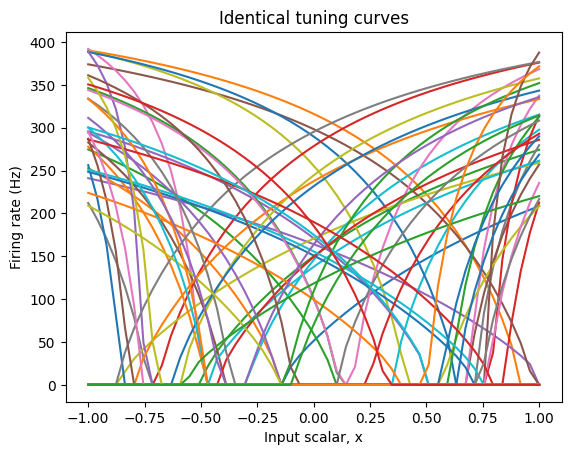

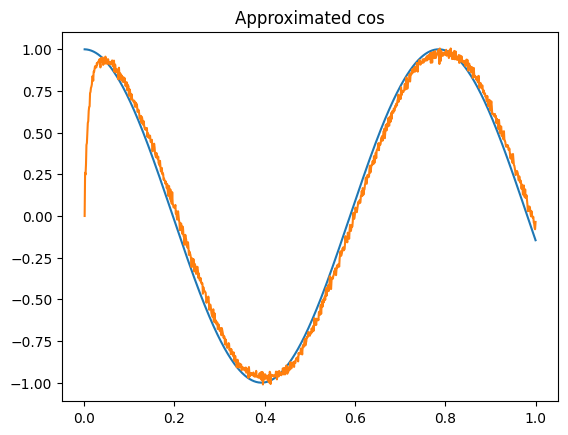

In [94]:
# inspect tuning curves
plt.plot(*tuning_curves(ens_1d, sim))
plt.ylabel("Firing rate (Hz)")
plt.xlabel("Input scalar, x")
plt.title("Identical tuning curves")
plt.show()

# inspect approximation
plt.plot(sim.trange(),sim.data[input_monitor])
plt.plot(sim.trange(),sim.data[listening_dendrite])
plt.title("Approximated cos")
plt.show()

## Weird 1
Many copies of a monotonically increasing tuning curve added to something with changing derivative?

## Weird 2
The neurons really like to spike around time 0.4, when they are supposed to have 0 spiking rate.

To figure out the weirdness, we can take a look at individual spiking activity.

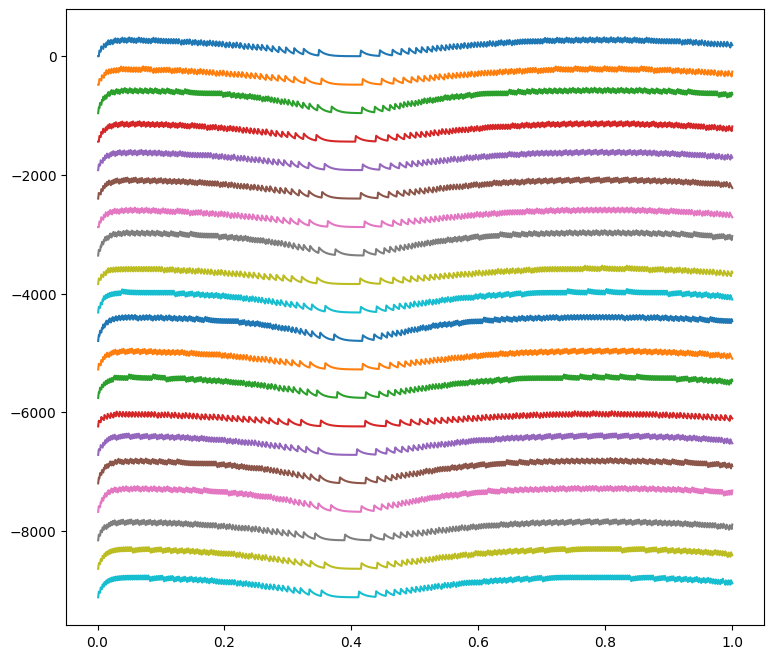

In [45]:
scale = 480
plt.figure(figsize=(9,8))
for i in range(20):
    plt.plot(sim.trange(), sim.data[individual_psc][:, i] - i * scale)
# plt.ylim(scale * (-ens_1d.n_neurons + 1), scale)
# plt.ylabel("Neuron")
# plt.yticks(
#     np.arange(scale / 1.8, (-ens_1d.n_neurons + 1) * scale, -scale), np.arange(ens_1d.n_neurons)
# )
plt.show()

## Not that weird 1
Although adding tuning curves would be hopeless, PSCs actually take the general shape of the input. They might be truncated if input goes below $J_thres$ but that does not happen due to the current choise of $J_thres$.

## Not that weird 2
The spiking rate is 0 only at an instant — that means the spiking **rate** is never 0. We can do a few things to alleviate this.


# Improvement: $J_{\text{thres}}$ buffer

Sneakily shift the function so that the listening dendrite does have to be limited.
Then make $J_{\text{thres}}$ a little higher so spike rate is actually 0 at function minimum.

In [89]:
model = nengo.Network()

with model:
    # increase ensemble radius from 1 to 2 because function shifted up
    ens_1d = nengo.Ensemble(64, dimensions=1,radius=2.5)
    ens_1d.encoders = Choice([[1]])
    ens_1d.intercepts = Choice([0.1])  # a little higher than 0
    input = nengo.Node(lambda t: np.cos(8*t) + 1)
    nengo.Connection(input, ens_1d, synapse=None)  # signal produced by voltage clamp, not synapse
    input_monitor = nengo.Probe(input)
    listening_dendrite = nengo.Probe(ens_1d, synapse=0.01)
    individual_psc = nengo.Probe(ens_1d.neurons, synapse=0.01)

In [ ]:
with nengo.Simulator(model) as sim:
    sim.run(1)


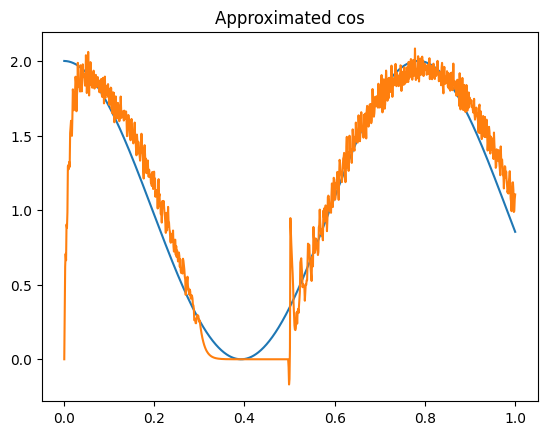

In [91]:
# inspect approximation
plt.plot(sim.trange(),sim.data[input_monitor])
plt.plot(sim.trange(),sim.data[listening_dendrite])
plt.title("Approximated cos")
plt.show()

# Yes.
If the function is not truncated by/too close to $J_{\text{thres}}$, then it can be approximated.

A counterexample with the Heaviside function is appended.

# Tuning curves are hella different from activation functions
A line tuning curve would work but you could never approximate a nonlinear ground truth without a non-linearity.

A constant tuning curve would not work though.


# Heaviside input
With tuning curves 0 on the heavy side

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

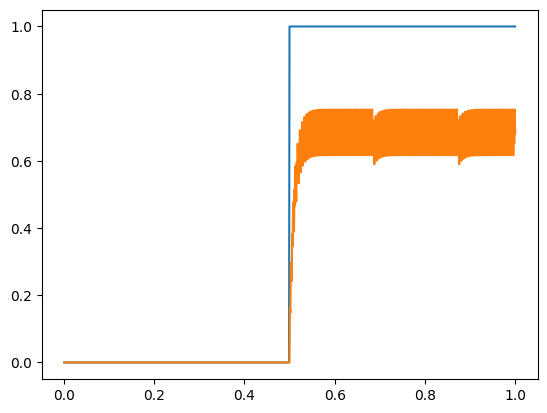

In [17]:
with model:
    ens_1d = nengo.Ensemble(1, dimensions=1)
    ens_1d.encoders = Choice([[-1]])  # All neurons have encoder [-1]
    ens_1d.intercepts = Choice([0])  # All neurons have x-intercept 0

    input = nengo.Node(lambda t: 0 if t<0.5 else 1)
    nengo.Connection(input, ens_1d, synapse=None)  # signal produced by voltage clamp, not synapse
    input_monitor = nengo.Probe(input)
    listening_dendrite = nengo.Probe(ens_1d, synapse=0.01)

# run
with nengo.Simulator(model) as sim:  # Create the simulator
    sim.run(1)  # Run it for 1 second

plt.plot(sim.trange(),sim.data[input_monitor])
plt.plot(sim.trange(),sim.data[listening_dendrite])